# Goals: Build a binary classification model using logistic regression + weight decay (L2 reg) from scratch

Use python and limited numpy functionality

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%matplotlib inline
seed=30
np.random.seed(seed)

# Metric

Activation function: sigmoid. Metric: log loss

In [2]:
from sklearn.metrics import accuracy_score

In [3]:
def logloss(y,y_pred):
    y = np.squeeze(y)
    y_pred= np.clip(np.squeeze(y_pred),1e-5,1-1e-5)
    return np.mean(-np.log(y_pred)*y - np.log(1-y_pred)*(1-y))

# Create linear binary classification dataset

In [19]:

def sigmoid(x):
    return 1/(1+np.exp(-x))

def get_linear_dataset_with_bias(n, dim,noise_bound=0.5):
    W = np.random.randn(dim+1,1)  
    
    X = np.random.randn(n,dim)
    X0 = np.array([[1]*n]).T # nx1
    X = np.concatenate((X0,X),axis=1)
    
    #add uniform random noise between negative and positive noise_bound
    vfunc=np.vectorize(lambda x: 1 if x >= .5 else 0)
    y = X.dot(W) + np.random.rand(n,1) * noise_bound*2 -noise_bound
    y = vfunc(sigmoid(y))
    return X,np.squeeze(y),W

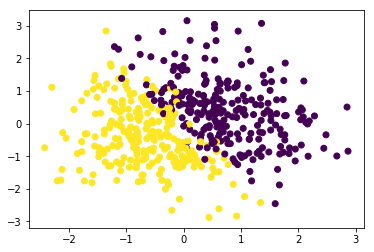

In [20]:
size=500
X,y,W = get_linear_dataset_with_bias(size,2,noise_bound=1)
plt.scatter(X[:,1],X[:,2],c=y)

# Logistic Regression Sklearn

In [21]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(X,np.squeeze(y),test_size=0.2,random_state=42)

In [31]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = seed,penalty='l2',C=7,max_iter=200)
lr.fit(X_train,y_train)
y_train_pred=lr.predict_proba(X_train)[:,1]
y_val_pred = lr.predict_proba(X_val)[:,1]
print('Log Loss on train set: ')
print(logloss(y_train,y_train_pred))
print('Log Loss on valid set: ')
print(logloss(y_val,y_val_pred))
print('Accuracy: ')
print(accuracy_score(y_val,lr.predict(X_val)))


LogisticRegression(C=7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=30, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Log Loss on train set: 
0.12909950574184997
Log Loss on valid set: 
0.17574749556308988
Accuracy: 
0.92


In [50]:
lr.coef_

array([[ 0.01330238, -6.48417458, -3.42818032]])

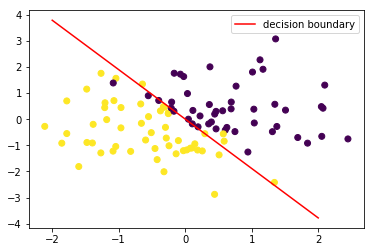

In [51]:
# plot validation set and decision boundary
plt.scatter(X_val[:,1],X_val[:,2],c=np.squeeze(y_val))

ex1 = np.linspace(-2, 2, 100)
ex2 = -(lr.coef_[:, 1] * ex1 + lr.intercept_) / lr.coef_[:,2]

plt.plot(ex1, ex2, color='r', label='decision boundary');
plt.legend()
plt.show()

# Logistic Regression with Gradient Descent and L2 regularization

In [33]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def sigmoid_grad(x_sigmoid):
    return x_sigmoid*(1-x_sigmoid)

def logloss_sigmoid_grad(y,y_pred):
    return (1/len(y))*(y_pred-y)

def initialize_weight(dim):
    W0 = np.array([[0]]) # bias, 1x1
    W= np.random.rand(dim,1)
#     W= np.zeros((dim,1))
    return np.concatenate((W0,W))

def plot_learning_curve(train_losses,val_losses):    
    plt.plot(range(len(train_losses)),train_losses,'o-',color='r',label='Training loss',markersize=1)
    plt.plot(range(len(train_losses)),val_losses,'o-',color='g',label='Validation loss',markersize=1)
    plt.legend(loc="best")
    plt.show()
class CustomLogisticRegression():
    def __init__(self,dim,lr,n_iteration=50,l2=0):
        np.random.seed(seed)
        self.dim,self.lr,self.n_iteration,self.l2 = dim,lr,n_iteration,l2
        self.W = initialize_weight(self.dim)
        self.train_losses=[]
        self.val_losses=[]
    def fit(self,X_train,y_train,validation):
        y_train = y_train[:,None] # shape (n,1)
        X_val,y_val = validation[0],validation[1][:,None]
        for i in range(self.n_iteration):      
            y_pred = X_train.dot(self.W)
            y_pred_sigmoid = sigmoid(y_pred)
            loss = logloss(y_train,y_pred_sigmoid)

            grad = logloss_sigmoid_grad(y_train,y_pred_sigmoid) # n x 1

            grad_w = X_train.T.dot(grad)

            #ignore update of grad_w0 (bias term) since w0 does not contribute to regularization process
            grad_w[1:,:]+= 2*(self.l2/X_train.shape[0])*self.W[1:,:] # (2 *lambda / m)* weight
            
            self.W-= self.lr*grad_w 
            
            #save training loss
            self.train_losses.append(loss)
            #predict validation set
            y_val_pred = self.predict_proba(X_val)
            val_loss = logloss(y_val,y_val_pred)
            self.val_losses.append(val_loss)
            if (i+1) % 100 == 0:
                print(f'{i+1}. Training loss: {loss}, Val loss:{val_loss}')
        
        plot_learning_curve(self.train_losses,self.val_losses)
    def predict_proba(self,X_test):
        if X_test.shape[1] == self.dim:
            X0 = np.array([[1]*X_test.shape[0]]).T # nx1
            X_test = np.concatenate((X0,X_test),axis=1)
        return np.squeeze(sigmoid(X_test.dot(self.W)))
    def predict(self,X_test,thres=0.5):
        if X_test.shape[1] == self.dim:
            X0 = np.array([[1]*X_test.shape[0]]).T # nx1
            X_test = np.concatenate((X0,X_test),axis=1)
        vfunc=np.vectorize(lambda x: 1 if x >= thres else 0)
        y_test_pred = sigmoid(X_test.dot(self.W))
        return np.squeeze(vfunc(y_test_pred))

100. Training loss: 0.172076341306875, Val loss:0.21426852666031138
200. Training loss: 0.1490921346804863, Val loss:0.19358879423827208
300. Training loss: 0.14052070950907142, Val loss:0.18582845127815958
400. Training loss: 0.1361511510259612, Val loss:0.18188977992339936
500. Training loss: 0.13358569111194907, Val loss:0.17959848229897907
600. Training loss: 0.1319510098213241, Val loss:0.17815683441010463
700. Training loss: 0.13085203253278394, Val loss:0.17720277522788636
800. Training loss: 0.1300847337031369, Val loss:0.17654899090515264
900. Training loss: 0.12953374334456566, Val loss:0.1760896463486764
1000. Training loss: 0.1291294095462433, Val loss:0.1757609761183615
1100. Training loss: 0.12882756909161247, Val loss:0.1755226544634025
1200. Training loss: 0.12859908835313666, Val loss:0.1753481981806221
1300. Training loss: 0.12842413887264958, Val loss:0.17521967165756877
1400. Training loss: 0.1282888840324576, Val loss:0.1751246395017985


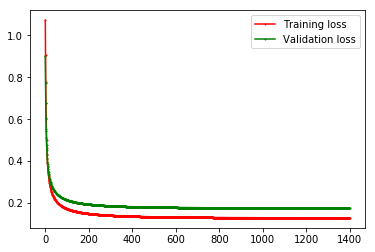

In [46]:
lr_scratch = CustomLogisticRegression(2,0.5,1400,l2=0.001)
lr_scratch.fit(X_train,y_train,validation=(X_val,y_val))

In [47]:
y_pred = lr_scratch.predict(X_val)
accuracy_score(y_val,y_pred)

0.92

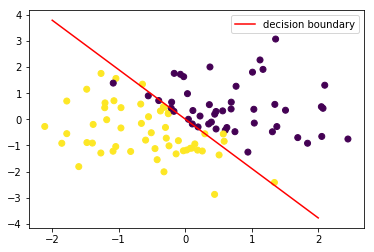

In [55]:
# plot validation set and decision boundary

plt.scatter(X_val[:,1],X_val[:,2],c=np.squeeze(y_val))

ex1 = np.linspace(-2, 2, 100)
ex2 = -(lr_scratch.W[1] * ex1 + lr_scratch.W[0]) / lr_scratch.W[2]

plt.plot(ex1, ex2, color='r', label='decision boundary');
plt.legend()
plt.show()

<b> Similar result to sklearn model!